## prepare

In [1]:
import io, os, sys, cv2, requests, time
import pandas as pd
from PIL import Image
from utils.camera import Camera
import torch
from torch.autograd import Variable
import torchvision.models as models
import torchvision.transforms as transforms

In [2]:
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION', "tbd ")
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
# !nvidia-smi
# call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

__Python VERSION: 3.6.9 (default, Oct  8 2020, 12:12:24) 
[GCC 8.4.0]
__pyTorch VERSION: 1.7.0
__CUDA VERSION tbd 
__CUDNN VERSION: 8000
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0


In [3]:
# load vgg16 model 
vgg = models.vgg16(pretrained=True)  # This may take a few minutes.

# load imagenet labels
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
response = requests.get(LABELS_URL)  # Make an HTTP GET request and store the response.
labels = {int(key): value for key, value in response.json().items()}

In [4]:
# transform pipeline
def do_prediction(img):
    # min size as noted in the PyTorch pretrained models doc: 224 px
    min_img_size = 224  
    transform_pipeline = transforms.Compose([transforms.Resize(min_img_size),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                              std=[0.229, 0.224, 0.225])])
    img_tensor = transform_pipeline(img)
    # print(type(img_tensor), img_tensor.shape)
    img_tensor = img_tensor.unsqueeze(0)  
    img_tensor = Variable(img_tensor)
    # print(type(img_tensor), img_tensor.shape)
    
    # returns a rensor of shape (batch, num class labels)
    prediction = vgg(img_tensor)  
    
    # prediction will be the index of the class label with the largest value
    prediction_max = prediction.data.numpy().argmax()  
    # print(labels[prediction_max]) 

    # find labels of top predictions
    df = pd.DataFrame(data=prediction.data.numpy().reshape(-1)).nlargest(10, 0).reset_index()
    df.columns=['id', 'value']
    df['label'] = df['id'].apply(lambda x : labels[x])
    return labels[prediction_max], df

## predict image from internet

In [5]:
IMG_URL = 'https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Cat03.jpg/1200px-Cat03.jpg'
response = requests.get(IMG_URL)
img = Image.open(io.BytesIO(response.content))  # Read bytes and store as an img

prediction, df = do_prediction(img)
print(prediction)
df.head()

Egyptian cat


,id,value,label
0,285,11.461210,Egyptian cat
1,282,10.788914,tiger cat
2,281,9.854652,"tabby, tabby cat"
3,478,9.004165,carton
4,463,8.670149,"bucket, pail"


## predict image from file

In [6]:
img = Image.open("images/dog.jpg")
prediction, df = do_prediction(img)
print(prediction)
df.head()

flat-coated retriever


,id,value,label
0,205,11.964660,flat-coated retriever
1,208,9.811812,Labrador retriever
2,805,9.714287,soccer ball
3,852,8.548815,tennis ball
4,232,7.908979,Border collie


## predict image fom camera

In [7]:
camera0 = Camera(capture_device=0, width=224, height=224, 
                     capture_width=1280, capture_height=720, capture_fps=30, flip_mode=-1, debug=True)



nvarguscamerasrc sensor-id=0 ! video/x-raw(memory:NVMM), width=1280, height=720,                 format=(string)NV12, framerate=(fraction)30/1 ! nvvidconv ! video/x-raw, width=(int)224,                 height=(int)224, format=(string)BGRx ! videoconvert ! appsink drop=true sync=false


In [21]:
for _ in range(20):
    img = camera0.get_image_rgb()
    img = Image.fromarray(img, 'RGB')
    prediction, df = do_prediction(img)
    print(prediction)

laptop, laptop computer
digital clock
mouse, computer mouse
mouse, computer mouse
remote control, remote
remote control, remote
carpenter's kit, tool kit
holster
wallet, billfold, notecase, pocketbook
wallet, billfold, notecase, pocketbook
home theater, home theatre
sandbar, sand bar
sandbar, sand bar
doormat, welcome mat
doormat, welcome mat
sandbar, sand bar
sandbar, sand bar
sandbar, sand bar
sandbar, sand bar
doormat, welcome mat


## test camera

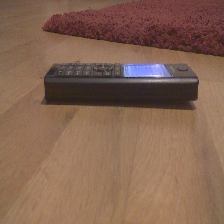

In [20]:
Image.fromarray(camera0.get_image_rgb(), 'RGB')